In [1]:
import os
os.chdir('/mnt/diploma')

In [2]:
!ls -l

итого 21404
-rw-rw-r-- 1 asciishell asciishell    93486 окт  5 23:40  01_vectorize_text.ipynb
-rw-rw-r-- 1 asciishell asciishell   230984 окт 31 18:07  02_kmeans_text_vectors.ipynb
-rw-rw-r-- 1 asciishell asciishell   358205 янв 25 00:31 '03_train_recurrent (0c07e603).ipynb'
-rw-rw-r-- 1 asciishell asciishell  1446044 янв 25 00:05  03_train_recurrent_catboost.ipynb
-rw-rw-r-- 1 asciishell asciishell   312322 окт 31 19:45 '20200912_tf embeder.ipynb'
drwxrwxr-x 1 asciishell asciishell     4096 янв 23 12:47  catboost_info
-rw-rw-r-- 1 asciishell asciishell   101991 сен  4 22:11  cli_tools.ipynb
drwxrwxr-x 1 asciishell asciishell     4096 сен  1 19:56  data
-rw-rw-r-- 1 asciishell asciishell     9309 окт 31 18:23  hse_dialog_tree-0.2.0-py3-none-any.whl
-rw-rw-r-- 1 asciishell asciishell     9296 янв 24 22:03  hse_dialog_tree-0.2.1-py3-none-any.whl
drwxrwxr-x 1 asciishell asciishell     4096 дек  6 19:56  junk
drwxrwxr-x 1 asciishell asciishell     4096 сен 22 13:15  models
-rw-rw-r-- 1 asc

In [3]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical

from hse_dialog_tree.kmeans_names import get_names
from hse_dialog_tree.utils.cpu import get_processor_info
from hse_dialog_tree.utils.files import load_pickle, dump_pickle

LANG = 'rus'
print(get_processor_info())

 Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz x 4


In [4]:
dramas = load_pickle(f'data/{LANG}/content_all.pkl.zip')

dramas_texts = []
for k, v in dramas.items():
    dramas_texts.append(v)

In [5]:
vectors = load_pickle(f'data/{LANG}/02_vectors_v2.pkl.zip')
sentence_to_vector = load_pickle(f'data/{LANG}/02_sentence_to_vector_v2.pkl.zip')

cluster_model_kmeans = load_pickle('steps/03_kmeans/kmeans_v2_044.pkl.zip')
cluster_names = get_names(cluster_model_kmeans)
assert cluster_names is not None

In [6]:
def ngrams_from_vector(vec, n=3):
    return [vec[i: i+n] for i in range(len(vec)-n + 1)]

In [7]:
cluster_vecs = []
cluster_vecs_text_no = []
for i, drama in enumerate(tqdm(dramas_texts)):
    for part in drama:
        clusters = []
        for person, sent in part:
            if sent not in sentence_to_vector:
                continue # Skip empty or too long texts
            sent_vec = sentence_to_vector[sent]
            cluster =  cluster_model_kmeans.predict(sent_vec.reshape(1, -1))[0]
            clusters.append(cluster)
        cluster_vecs.append(clusters)
        cluster_vecs_text_no.append(i)

  0%|          | 0/210 [00:00<?, ?it/s]

In [8]:
all_ngrams = []

for clusters_vec in tqdm(cluster_vecs):
    all_ngrams.extend(ngrams_from_vector(clusters_vec, n=3))

  0%|          | 0/5869 [00:00<?, ?it/s]

In [9]:
len(all_ngrams)

198708

In [10]:
from collections import Counter
ngram_counter = Counter([','.join([cluster_names.get(x, str(x)) for x in ngram]) for ngram in all_ngrams if ngram != []])

for ng, cnt in list(({k: v for k, v in sorted(ngram_counter.items(), key=lambda item: -item[1])}).items())[:10]:
    print('{:<20}\t{:<20}\t{:<20}\t{}'.format(ng.split(',')[0], ng.split(',')[1], ng.split(',')[2], cnt))

Воля                	 честь              	 отвага             	231
Царь                	Царь                	Царь                	204
Повествование       	 высокий слог       	Воля                	142
Воля                	 честь              	 отвага             	131
Воля                	 честь              	 отвага             	123
Повествование       	 высокий слог       	Воля                	117
Повествование       	 высокий слог       	Повествование       	102
Повествование       	 высокий слог       	Повествование       	98
Жених               	 невеста            	Жених               	97
О любви             	О любви             	О любви             	94


In [11]:
clusters_num = 44

# Моя реализация сети

In [12]:
cluster_vecs_text_no_train, _ = train_test_split(list(set(cluster_vecs_text_no)), test_size=0.2, random_state=42)

In [13]:
len(cluster_vecs), len(cluster_vecs_text_no)

(5869, 5869)

In [14]:
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = [], [], [],[]
X_lstm_all, y_lstm_all = [], []
X_ngrams_all = []
for vec, text_no in zip(tqdm(cluster_vecs), cluster_vecs_text_no):
    if len(vec) < 3:
        continue
    for ngrams in ngrams_from_vector(vec, n=4):
        X_lstm = np.array([cluster_model_kmeans.cluster_centers_[cl] for cl in ngrams[:-1]])
        y_lstm = to_categorical(ngrams[-1], num_classes=clusters_num)
        
        X_ngrams_all.append(ngrams[:-1])
        X_lstm_all.append(X_lstm)
        y_lstm_all.append(y_lstm)
        if text_no in cluster_vecs_text_no_train:
            X_lstm_train.append(X_lstm)
            y_lstm_train.append(y_lstm)
        else:
            X_lstm_test.append(X_lstm)
            y_lstm_test.append(y_lstm)

X_lstm_train = np.array(X_lstm_train)
X_lstm_test = np.array(X_lstm_test)
y_lstm_train = np.array(y_lstm_train)
y_lstm_test = np.array(y_lstm_test)
X_lstm_all = np.array(X_lstm_all)
y_lstm_all = np.array(y_lstm_all)
X_ngrams_all = np.array(X_ngrams_all)
print(len(X_lstm_train))     

  0%|          | 0/5869 [00:00<?, ?it/s]

145084


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

In [16]:
clusters_num = 44
hidden_size = 10

model = Sequential()
model.add(layers.LSTM(128, input_shape=X_lstm.shape))
# model.add(layers.TimeDistributed(Dense(128, activation='tanh')))
# model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(clusters_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

model.fit(X_lstm_train, y_lstm_train, validation_data=(X_lstm_test, y_lstm_test),
          epochs=5, verbose=1,
         )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               328192    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                2

In [17]:
cluster_seq_emb = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [18]:
ngrams_vecs = cluster_seq_emb.predict(X_lstm_all)

# Kmeans 2

In [19]:
ngram_kmeans = MiniBatchKMeans(n_clusters=50, random_state=42)
ngram_clusters = ngram_kmeans.fit_predict(ngrams_vecs)

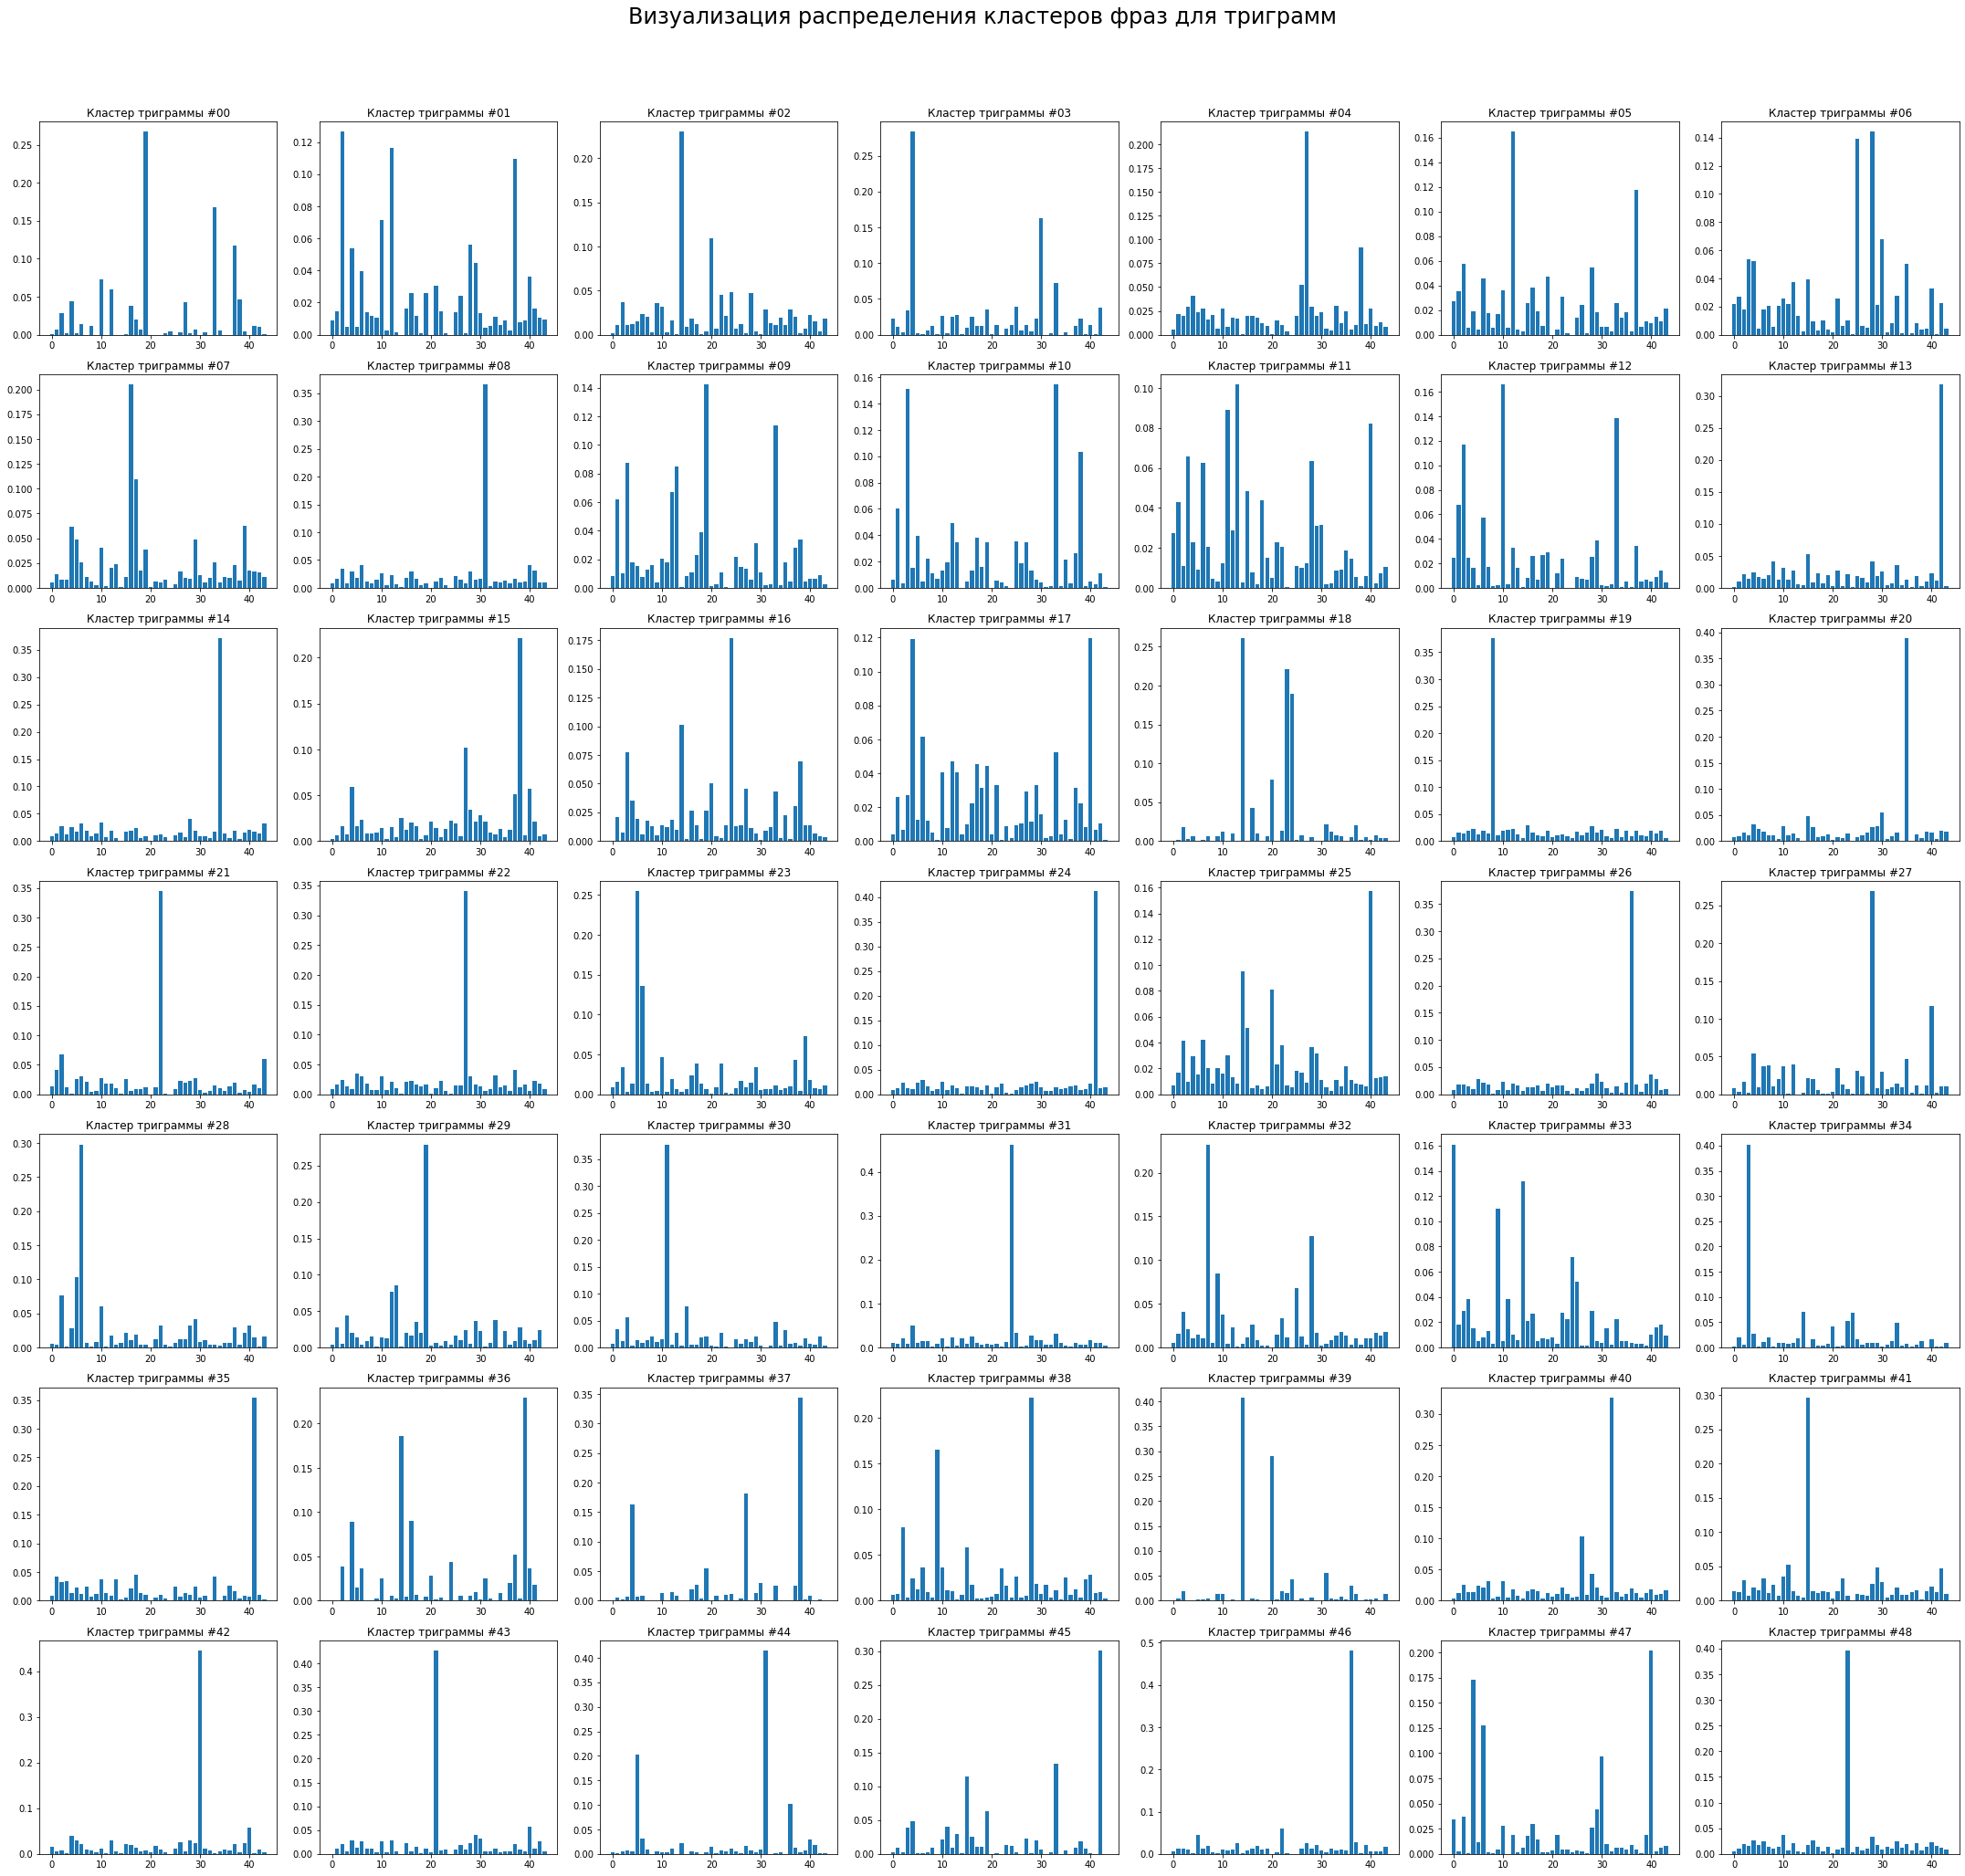

In [20]:
plt.figure(figsize=(30, 30), facecolor='w')
plt.suptitle('Визуализация распределения кластеров фраз для триграмм', fontsize=24)
for cluster_num in range(49):
    plt.subplot(7, 7, cluster_num + 1)
    counter = [0 for i in range(44)]
    for row in X_ngrams_all[ngram_clusters == cluster_num]:
        for it in row:
            counter[it] += 1
    counter = np.array(counter)
    counter = counter / counter.sum()
    
    plt.bar(range(len(counter)) , counter)
    plt.title('Кластер триграммы #{:02d}'.format(cluster_num))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Graph

Перебираем все кластера

Берем те ngramms, последовательность которых относится к данному кластеру

Строим граф - будет словарем, в ключе кортеж двух кластеров, в значении следующий

In [21]:
c = Counter()
c.update(ngram_clusters)
c.most_common()[-10:]

[(46, 1816),
 (43, 1738),
 (33, 1599),
 (0, 1461),
 (45, 1234),
 (18, 849),
 (34, 831),
 (37, 511),
 (44, 490),
 (36, 282)]

In [22]:
# кластер-диалог, кортеж-ключ, кластер-фразы
graph = {}
for cluster_num in range(ngram_kmeans.n_clusters):
    graph_ngrams = X_ngrams_all[ngram_clusters == cluster_num]
    graph[cluster_num] = defaultdict(set)
    for row in graph_ngrams:
        key = tuple(row[:-1])
        val = row[-1]
        graph[cluster_num][key].add(val)

In [23]:
# кластер-диалог, кластер-фразы до, кластер-фразы после
graph_simple = {}
for k, v in graph.items():
    graph_simple[k] = defaultdict(set)
    for k2, v2 in graph[k].items():
        for key1, key2 in zip(k2, k2[1:]):
            graph_simple[k][key1].add(key2)
        for x in v2:
            graph_simple[k][k2[-1]].add(x)

In [24]:
# кластер-диалог, название кластера фразы до, название кластера фразы после
graph_named = {}
for k, v in graph_simple.items():
    graph_named[k] = {}
    for k2, v2 in graph_simple[k].items():
        key = cluster_names[k2]
        val = [cluster_names[x] for x in v2]
        graph_named[k][key] = val

In [25]:
g = Digraph('G', filename='junk/graph_nums.gv')
for k, v in graph_simple[36].items():
    for text in v:
        g.edge(str(k), str(text))
g.view()

'junk/graph_nums.gv.pdf'

In [26]:
g = Digraph('G', filename='junk/graph_text.gv')
for k, v in graph_named[36].items():
    for text in v:
        g.edge(str(k), str(text))
g.view()

'junk/graph_text.gv.pdf'

In [27]:
# KV storage: ngram cluster -> list of text
cluster_to_text = defaultdict(list)
for i, drama in enumerate(tqdm(dramas_texts)):
    for part in drama:
        clusters = []
        for person, sent in part:
            if sent not in sentence_to_vector:
                continue # Skip empty or too long texts
            sent_vec = sentence_to_vector[sent]
            cluster =  cluster_model_kmeans.predict(sent_vec.reshape(1, -1))[0]
            cluster_to_text[cluster].append(sent)

  0%|          | 0/210 [00:00<?, ?it/s]

In [28]:
import random
import typing

def print_random_path(graph:typing.Dict[int, typing.Iterable], count=3, node=None, seed=None):
    r = random.Random(seed)
    if node is None:
        node = r.choice(list(graph.keys()))
    for i in range(count):
        node_name = cluster_names[node]
        node_text = r.choice(cluster_to_text[node])
        print('{:>4} {:<30}\t{}\n'.format(node, node_name, node_text))
        node = r.choice(list(graph[node]))

In [29]:
print_random_path(graph_simple[9], count=5, seed=42)

  21 Думать, вспомнить             	Ах! как хорошо! Как чудно хорошо теперь мне здесь!.. Тепло, светло, легко!.. Как будто в мире Очарований... будто сон волшебный Играет мной... И чтоб сберечь на память, Чтоб мне с собой унесть хоть что-нибудь В свидетельство и взорам и мечтам, Чтоб чудный сон мне стал заветной былью, Позвольте!..

  19 Короткий вопрос               	Имеете предписание?

  15 Небольшое повествование       	Господа, пожалуйте в эту комнату: мы тотчас к вам будем. Что ж ты вздумал?

   8 Место, направление            	Мое место здесь.

  16 Суждение                      	Я догоню солдата-то да назад ему отдам.



In [30]:
print_random_path(graph_simple[9], count=5, seed=40)

  30 Обращения                     	Алексей не сумеет понять?.. Нет, вы шутите, Антон Игнатьич?

  13 Краткий ответ                 	Так будет.

  12 Вопрос, предложение с "как"   	Успокойтесь, прошу вас… вы так бледны… Здоровы ли вы?

  42 О времени                     	Не долго ждать тебе.

  17 "Знаю"                        	Познай ты нас, познай по тяжкому стенанью!



In [31]:
matrix = np.zeros(shape=(cluster_model_kmeans.n_clusters, cluster_model_kmeans.n_clusters))
for cluster_num in range(cluster_model_kmeans.n_clusters):
    for k, v in graph_simple[cluster_num].items():
        for vv in v:
            matrix[k, vv] = 1
matrix.mean()

1.0

In [32]:
_name = 'junk/03_train_recurrent_01/'
os.mkdir(_name)
model.save(_name + 'tf.hdf5')
dump_pickle(ngram_kmeans, _name + 'kmeans.pkl.zip')

В данной модели получаем низкое качество "адекватности" графа. 
На вход нейронной сети подаются центроиды кластеров, из-за этого теряется информация о самих предложениях.

Возможно число комбинаций $44^3 =85184$ так же мало и меньше числа коротких диалогов.
То есть, некоторые комбинации входных данных могут повторяться и при этом иметь разные целевые переменные.

Дополнительно была обучена модель CatBoostClassifier на входных векторах. 
Accuracy на обучающей выборке не поднималось выше 0,15 (случайная модель дает 0,025).
Эксперименты с архитектурой не могли привысить accuracy на тестовой выборке выше 0,089.

К тому же, не совсем ясно как выбирать предложение по выбранным кластерам. 
Случайное никак не будет связано по смыслу или контексту, но может иметь похожую тематику.

Следует пересмотреть подход к выполнению экспериментов.
Идея -- подавать на вход не центроиды, а сами вектора фраз.